In [1]:
import re
import ckanapi
import time
import pandas as pd
import geopandas

import panel as pn
import param
pn.extension()

import geojson
from shapely.geometry import shape, Point
import folium
import matplotlib.pyplot as plt


### Set up a ckanapi client to query IOOS Catalog

In [2]:
from ckanapi import RemoteCKAN
ua = 'ckanapiioos/1.0 (+https://ioos.us/)'

#ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua, get_only=True)
ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua)
ioos_catalog


### Test CKAN API by running some example queries

Queries below are representative of what will be run later in the notebook using the pulldowns for parameter selection

In [3]:
orgs = ioos_catalog.action.organization_list()
print(orgs)

['aoos', 'caricoos', 'cdip', 'cencoos', 'comt', 'gcoos', 'glider-dac', 'glos', 'hf-radar-dac', 'ioos', 'maracoos', 'nanoos', 'neracoos', 'noaa-co-ops', 'noaa-ndbc', 'oceansites', 'pacioos', 'sccoos', 'secoora', 'unidata', 'usgs', 'us-navy']


### Let's query some packages by CF Standard Name:

Example command line execution of ckanapi:
```
ckanapi action package_search -r https://data.ioos.us q=res_format:ERDDAP-TableDAP fq=cf_standard_names:mass_concentration_of_oxygen_in_sea_water rows=1
```

First, if we filter only for `cf_standard_names:mass_concentration_of_oxygen_in_sea_water`, we should get around 556 datasets:

In [4]:
datasets = ioos_catalog.action.package_search(fq='+cf_standard_names:mass_concentration_of_oxygen_in_sea_water', rows=50)
datasets['count']

574

Next, if we filter only for `res_format:ERDDAP-TableDAP` and `cf_standard_names:mass_concentration_of_oxygen_in_sea_water`, we should get around 489 datasets.  

This would be the query to use if we wanted to retrieve some actual data from each of the resulting datasets in a consistent way via ERDDAP/erddapy.

In [5]:
datasets = ioos_catalog.action.package_search(q='+res_format:ERDDAP-TableDAP', fq='+cf_standard_names:mass_concentration_of_oxygen_in_sea_water', rows=50)
datasets['count']

507

For testing purposes, let's reduce the results futher by adding a filter for `organization:gcoos`.  Datasets returned: ~143. 

In [6]:
datasets = ioos_catalog.action.package_search(q='+res_format:ERDDAP-TableDAP +organization:gcoos', fq='+cf_standard_names:mass_concentration_of_oxygen_in_sea_water', rows=50)
datasets['count']

143

To reduce even further for testing, we can use `organization:cencoos` which only includes ~ 49 datasets.  We use this query to set up a basic iterator that will retrieve all the results via successive requests, in groups of 10 datasets at a time. 
 
For each dataset, we print the title and then move to the next 10 results until all are returned.  This is the basic CKAN API iteration used for the rest of the queries in the notebook.

In [7]:
result_count = 0

while True:
    datasets = ioos_catalog.action.package_search(q='+res_format:ERDDAP-TableDAP +organization:cencoos', fq='+cf_standard_names:mass_concentration_of_oxygen_in_sea_water', rows=10, start=result_count)
    num_results = datasets['count']
    print(f"num_results: {num_results}, result_count: {result_count}")
    for dataset in datasets['results']:
        print(dataset['title'])
        
        result_count = result_count + 1
    time.sleep(1)
    if(result_count >= num_results):
        print(f"num_results: {num_results}, result_count: {result_count}")
        break



num_results: 49, result_count: 0
ACCESS CTD (Station 6-E), Line 6, Station E
DRY CREEK BELOW LAMBERT BRIDGE NEAR GEYSERVILLE NEAR HEALDSBURG 4NW
ACCESS CTD (Station 6-M), Line 6, Station M
ACCESS CTD (Station 4-EX), Line 4, Station EX
Azevedo Pond (elkapwq)
SUISUN BAY A VAN SICKLE ISLAND NR PITTSBURG CA
North Marsh (elknmwq)
Boca Rio
Second Mallard (sfbsmwq)
ACCESS CTD (Station 6-MW), Line 6, Station MW
num_results: 49, result_count: 10
* CeNCOOS in situ water quality monitoring at Carquinez at the California Maritime campus.
ACCESS CTD (Station 6-ME), Line 6, Station ME
ACCESS CTD (Station 2-M), Line 2, Station M
ACCESS CTD (Station 2-ME), Line 2, Station ME
SANTA YNEZ R A SOLVANG CA
South Marsh (elksmwq)
* CeNCOOS in situ water monitoring data at Trinidad Head, California
China Camp (sfbccwq)
Vierra Mouth (elkvmwq)
ACCESS CTD (Station 6-W), Line 6, Station W
num_results: 49, result_count: 20
Oneonta Slough
RUSSIAN RIVER AT DIGGERS BEND NEAR HEALDSBURG 2NNE
DRY C BLW LAMBERT BR NR GEY

### Query IOOS Catalog to Populate Parameter Pulldowns

We can query CKAN API endpoints to populate pulldown menus for filter criteria for dataset queries.  Endpoints available to populate information from CKAN database include:
- [tag_list](https://docs.ckan.org/en/latest/api/index.html#ckan.logic.action.get.tag_list)
- [organization_list](https://docs.ckan.org/en/latest/api/index.html#ckan.logic.action.get.organization_list)

Use ckanapi to query these IOOS Catalog endpoints for values. Some filtering is necessary for things like tag_list to restrict to CF Standard Names (approximately).

In [8]:
tags = ioos_catalog.action.tag_list()
organizations = ioos_catalog.action.organization_list()
organizations.insert(0,None)

for i, org in enumerate(organizations):
    print(f"i: {i}, org: {org}")
    if i >= 10: break

i: 0, org: None
i: 1, org: aoos
i: 2, org: caricoos
i: 3, org: cdip
i: 4, org: cencoos
i: 5, org: comt
i: 6, org: gcoos
i: 7, org: glider-dac
i: 8, org: glos
i: 9, org: hf-radar-dac
i: 10, org: ioos


Next, filter this list using regex to only include tags that match the CF Standard Name patterns (underscore ('_') between text phrases).

We need to use one of the acceptable approaches to removing elements from a list in Python like `filter` or list comprehension (ie not iterating usina a for in loop becuase the indexes get messed up ):

In [9]:
print(f"tags length: {len(tags)}")

# any will work:
#p = re.compile("\S*_\S*")
#p = re.compile(".*_.*")
p = re.compile("_+?")
#p = re.compile("_+")
#p = re.compile("_{1}")

# doesn't work (matches anything):
#p = re.compile("_*")

tags_filtered = list(filter(lambda tag: p.search(tag), tags))
#tags_filtered = [tag for tag in tags if p.search(tag)]

# filter whitespace and bracket characters:
whitespace = re.compile("\s+?")
bracket = re.compile("[<>]")
tags_filtered = list(filter(lambda tag: not whitespace.search(tag) and not bracket.search(tag), tags_filtered))
tags_filtered.insert(0,None)

# print out the first 10 tags in tags_filtered:
print(f"tags_filtered length: {len(tags_filtered)}")
for i, tag in enumerate(tags_filtered):
    print(f"i: {i}, tag: {tag}")
    if i >= 10: break

tags length: 5285
tags_filtered length: 643
i: 0, tag: None
i: 1, tag: accepted_aphia_database_identification_number
i: 2, tag: accepted_authority_name
i: 3, tag: accepted_authorship_information
i: 4, tag: accepted_identification_number
i: 5, tag: accepted_name
i: 6, tag: accepted_name_usage
i: 7, tag: accepted_scientific_name
i: 8, tag: aggregate_quality_flag
i: 9, tag: air_pressure
i: 10, tag: Air_Pressure


For CKAN Resource Formats, according to the [CKAN API docs](https://docs.ckan.org/en/latest/api/index.html) there doesn't appear to be an API function to obtain a list, so instead we just create it manually.

In [10]:
formats = ['OPeNDAP','ERDDAP-TableDAP','ERDDAP-GridDAP','ERDDAP-WMS','SOS','HTML','WCS','WMS','WFS','XML','PDF','TXT']
formats.insert(0,None)
for i, tag in enumerate(formats):
    print(f"i: {i}, tag: {tag}")
    if i >= 10: break

i: 0, tag: None
i: 1, tag: OPeNDAP
i: 2, tag: ERDDAP-TableDAP
i: 3, tag: ERDDAP-GridDAP
i: 4, tag: ERDDAP-WMS
i: 5, tag: SOS
i: 6, tag: HTML
i: 7, tag: WCS
i: 8, tag: WMS
i: 9, tag: WFS
i: 10, tag: XML


Create a Param selector to choose a CF Standard Name for query:

In [11]:
class CatalogParams(param.Parameterized):
    #sel_cf_std_name = param.ListSelector(objects=tags_filtered, default=None, allow_None=True, label="Select a CF Standard Name:")
    #sel_cf_std_name = param.ObjectSelector(objects=tags_filtered, default=tags_filtered[0], allow_None=True, label="Select a CF Standard Name:")
    sel_cf_std_name = param.ObjectSelector(objects=tags_filtered, default='mass_concentration_of_oxygen_in_sea_water', allow_None=True, label="Select a CF Standard Name:")
    sel_organization = param.ObjectSelector(objects=organizations, default=None, allow_None=True, label="Select an Organization:")
    sel_format = param.ObjectSelector(objects=formats, default=None, allow_None=True, label="Select a Format:")
    sel_plot_type = param.ObjectSelector(objects=['Static Map','Heat Map'], default='Static Map', allow_None=False, label="Select a Plot Type:")
chart_params = CatalogParams()
chart_params


CatalogParams(name='CatalogParams00007', sel_cf_std_name='mass_concentration_of_oxygen_in_sea_water', sel_format=None, sel_organization=None, sel_plot_type='Static Map')

Define a Panel layout to hold our parameter selection pulldowns:

In [12]:
gspec = pn.GridSpec(sizing_mode='stretch_height', height_policy='fit')
gspec[0, 0] = chart_params
gspec

GridSpec(height_policy='fit', ncols=1, nrows=1, sizing_mode='stretch_height')
    [0] Column(margin=5, name='CatalogParams', sizing_mode='stretch_height', width=600)
        [0] StaticText(value='<b>CatalogParams</b>')
        [1] Select(options=OrderedDict([('None', ...]), value='mass_concentration_of_oxy...)
        [2] Select(options=OrderedDict([('None', ...]))
        [3] Select(options=OrderedDict([('None', ...]))
        [4] Select(options=OrderedDict([('Static Map'...]), value='Static Map')

### Query the IOOS Catalog CKAN API and perform some analysis:

Basic workflow:
- generate a query to pass via ckanapi
- parse results into a Pandas DataFrame for analysis
- create a GeoPandas GeoDataFrame to create some maps

#### Create parse_result() function to handle response

First, we make a function that can parse the CKAN API `package_search` JSON results list into a Python dict with attributes of interest.  

This can then be used to create a Pandas dataframe for further analysis.  Fields from result items currently parsed in `parse_result`:

```
# First-level properties:
metadata_created
metadata_modified
name
notes
num_resources
num_tags
title

# Other: 
organization -> title
organization -> image_url
organization -> description

# Extras:
bbox-east-long
bbox-west-long
bbox-north-lat
bbox-south-lat

cf_standard_names
contact-email
contributor_email
contributor_name
contributor_role
contributor_url

creator_country
creator_email
creator_name
creator_sector
creator_url

distributor-info
dataset-reference-date
gcmd_keywords
gts_ingest
ioos_ingest
infoUrl
instrument
license

metadata-date
name

platform
platform_id
platform_name
platform_vocabulary

publisher_country
publisher_email
publisher_name
publisher_url

resource-type
responsible-organization
responsible-parties

spatial
spatial-data-service-type
spatial-reference-system

standard_name_vocabulary

temporal-extent-begin
temporal-extent-end
temporal_start
temporal_end

use-constraints
use-limitations

vertical_max
vertical_min

waf_location
harvest_source_title
```

In [13]:
def parse_result(result):
    result_dict = {}
    
    # create lists of data fields from the result dict that we want to parse:
    #    extras_keys: key values of dataset 'extras' dicts
    #    first_level_props: first level keys in the result dict
    extras_keys = ['bbox-east-long','bbox-west-long','bbox-north-lat','bbox-south-lat','cf_standard_names','contact-email','contributor_email', \
                   'contributor_name','contributor_role','contributor_url', 'creator_country','creator_email','creator_name','creator_sector', \
                   'creator_url','dataset-reference-date','distributor-info','gcmd_keywords','gts_ingest','ioos_ingest','infoUrl','instrument', \
                   'license','metadata-date','name','platform','platform_id','platform_name','platform_vocabulary','publisher_country','publisher_email', \
                   'publisher_name','publisher_url','responsible-organization','responsible-parties','resource-type','spatial', \
                   'spatial-data-service-type','spatial-reference-system','standard_name_vocabulary', 'temporal-extent-begin','temporal-extent-end', \
                   'temporal_start','temporal_end','use-constraints','use-limitations','vertical_max', 'vertical_min','waf_location','harvest_source_title']
    
    first_level_props = ['metadata_created','metadata_modified','name','notes','num_resources','num_tags','title']
    
    # parse:
    # for extras, we have to scan the list of extras dict items to see if one with a matching key value is found:
    for extra in result['extras']:
        if extra['key'] in extras_keys:
            result_dict[extra['key']] = extra['value']
        # this would add in all the extra['key'] fields into the dict, which isn't necessary:
        #else: result_dict[extra['key']] = None
    
    #print(result_dict.keys())
    # add any fields not found in extra['key'] as None to ensure no missing fields in dict/DataFrame
    for key in extras_keys:
        if key not in result_dict.keys():
            result_dict[key] = None
        
    # for first-level properties, just assign the value to result_dict:
    for prop in first_level_props:
         result_dict[prop] = result[prop]
            
    # special cases - extract organization -> title, image_url, description:
    result_dict['organization-title'] = result['organization']['title']
    result_dict['organization-image_url'] = result['organization']['image_url']
    result_dict['organization-description'] = result['organization']['description']
    return result_dict 

#### Submit a query to the CKAN API with parameters of interest

In [14]:
result_rows = 50
result_count = 0
max_results = 5000
list_of_datasets = []
datasets_dict = {}

q = ""
q = q + f" +organization:{chart_params.sel_organization}" if chart_params.sel_organization is not None else q
q = q + f" +res_format:{chart_params.sel_format}" if chart_params.sel_format is not None else q
print(f"q: {q}")
    
fq = ""
fq = fq + f" +cf_standard_names:{chart_params.sel_cf_std_name}" if chart_params.sel_cf_std_name is not None else fq
print(f"fq: {fq}")

while True:
    #datasets = ioos_catalog.action.package_search(q='+res_format:ERDDAP-TableDAP +organization:cencoos', fq='+cf_standard_names:mass_concentration_of_oxygen_in_sea_water', rows=10, start=result_count)
    #datasets = ioos_catalog.action.package_search(q='+res_format:ERDDAP-TableDAP +res_format:OPeNDAP', fq='+cf_standard_names:mass_concentration_of_oxygen_in_sea_water', rows=50, start=result_count)
    datasets = ioos_catalog.action.package_search(q=q, fq=fq, rows=result_rows, start=result_count)
    num_results = datasets['count']
    print(f"num_results: {num_results}, result_count: {result_count}")
    
    # let's add a check to avoid processing too many results:
    if num_results > max_results: 
        print(f"Your query returned > {max_results} results.  Try adjusting the parameters to be more selective - the IOOS Catalog server will thank you.")
        break
        
    # if we return a large number of results (max_results/2), adjust the result_rows value higher to reduce roundtrips:
    if num_results > max_results / 2:
        result_rows = max_results / 10
    elif num_results > max_results / 5:
        result_rows = max_results / 25
    
    for dataset in datasets['results']:
        datasets_dict = parse_result(dataset)
        list_of_datasets.append(datasets_dict)
        result_count = result_count + 1
    time.sleep(1)
    if(result_count >= num_results):
        print(f"num_results: {num_results}, result_count: {result_count}")
        break

# output datasets_dict.keys() and an example dataset:
print(f"datasets_dict_keys: {datasets_dict.keys()}")
if len(list_of_datasets) > 0: [print(key,':',value) for key, value in list_of_datasets[0].items()]
#if len(list_of_datasets) > 0: print(json.dumps(list_of_datasets[0], indent=4))

q: 
fq:  +cf_standard_names:mass_concentration_of_oxygen_in_sea_water
num_results: 574, result_count: 0
num_results: 574, result_count: 50
num_results: 574, result_count: 100
num_results: 574, result_count: 150
num_results: 574, result_count: 200
num_results: 574, result_count: 250
num_results: 574, result_count: 300
num_results: 574, result_count: 350
num_results: 574, result_count: 400
num_results: 574, result_count: 450
num_results: 574, result_count: 500
num_results: 574, result_count: 550
num_results: 574, result_count: 574
datasets_dict_keys: dict_keys(['bbox-east-long', 'bbox-north-lat', 'bbox-south-lat', 'bbox-west-long', 'cf_standard_names', 'contact-email', 'dataset-reference-date', 'distributor-info', 'gcmd_keywords', 'metadata-date', 'resource-type', 'responsible-parties', 'spatial', 'spatial-data-service-type', 'spatial-reference-system', 'temporal-extent-begin', 'temporal-extent-end', 'temporal_end', 'temporal_start', 'use-constraints', 'use-limitations', 'waf_location', 

#### Convert the GeoJSON 'spatial' column to Shapely geometry object to use with GeoPandas

Resulting fields/columns:
- 'spatial': Shapely Polygon
- 'spatial_point': Shapely Polygon and Point (depending on the size of the original polygon bounding box)
- 'spatial_geojson': GeoJSON text field, the original 'spatial' field value from CKAN API

WKT is supposed to work according to the [docs](https://geopandas.org/gallery/create_geopandas_from_pandas.html), but seems to fail.

In [15]:
#df = pd.DataFrame(list_of_datasets).dropna(subset=[df.spatial])
df = pd.DataFrame(list_of_datasets)
df.dropna(subset=['spatial'], inplace=True)


# create a new column to store the original 'spatial' column (which is GeoJSON format):
df['spatial_geojson'] = df.spatial

# convert the 'spatial' column from GeoJSON to Shapely geometry for GeoPandas compatibility:
df.spatial = df.spatial.apply(lambda x: shape(geojson.loads(x)))



Create a new 'spatial_point' column of Shapely geometry objects that converts any geometries where the difference between lat/lon min and max is < .0001 degree to Point, and retains all the others as Polygon:

In [16]:
# the approach below uses abs() account for postive/negative lat/lon coordinates to perform the calculation correctly for all quadrants on the globe (or for features crossing meridian/equator)
df['spatial_point'] = df.apply(lambda row: row.spatial if abs(abs(float(row['bbox-west-long'])) - abs(float(row['bbox-east-long']))) > 0.0001 and abs(abs(float(row['bbox-north-lat'])) - abs(float(row['bbox-south-lat']))) > 0.0001 else Point(float(row['bbox-east-long']), float(row['bbox-south-lat'])), axis=1)

# same as above but without using abs():
#df['spatial_point'] = df.apply(lambda row: row.spatial if float(row['bbox-east-long']) - float(row['bbox-west-long']) > 0.0001 and float(row['bbox-north-lat']) - float(row['bbox-south-lat']) > 0.0001 else Point(float(row['bbox-east-long']), float(row['bbox-south-lat'])), axis=1)

# this just converts every tow to a Point object:
#df['#spatial_point'] = df.apply(lambda row: Point(float(row['bbox-east-long']), float(row['bbox-south-lat'])), axis=1)

df

,bbox-east-long,bbox-north-lat,bbox-south-lat,bbox-west-long,cf_standard_names,contact-email,contributor_email,contributor_name,contributor_role,contributor_url,...,metadata_modified,notes,num_resources,num_tags,title,organization-title,organization-image_url,organization-description,spatial_geojson,spatial_point
0,-76.37274,35.09988,35.09986,-76.37276,"[""aggregate_quality_flag"", ""altitude"", ""ammoni...",",None,water_resources@ncsu.edu,askusda@usda.go...",",None,water_resources@ncsu.edu,askusda@usda.go...",North Carolina Department of Environment and N...,"contributor,funder,funder,funder,funder,funder...",https://deq.nc.gov/about/divisions/water-resou...,...,2021-06-08T07:43:14.176069,Timeseries data from 'Pamlico Sound at PS9 (Mo...,5,56,Pamlico Sound at PS9 (ModMon),SECOORA,https://s3.amazonaws.com/oceansmap/ioos/logos/...,"SECOORA, the Southeast Coastal Ocean Observing...","{""type"": ""Polygon"", ""coordinates"": [[[-76.3727...",POINT (-76.37273999999999 35.09986)
1,-80.43799,32.55581,32.55579,-80.43801,"[""altitude"", ""depth"", ""fractional_saturation_o...",alison.krepp@noaa.gov,feedback@axiomdatascience.com,Axiom Data Science,processor,https://www.axiomdatascience.com,...,2021-06-08T07:42:55.932956,Timeseries data from 'Mosquito Creek' (urn:ioo...,5,19,Mosquito Creek,SECOORA,https://s3.amazonaws.com/oceansmap/ioos/logos/...,"SECOORA, the Southeast Coastal Ocean Observing...","{""type"": ""Polygon"", ""coordinates"": [[[-80.4380...",POINT (-80.43799 32.55579)
2,-81.24595,29.737051,29.737031,-81.24597,"[""altitude"", ""depth"", ""fractional_saturation_o...",alison.krepp@noaa.gov,feedback@axiomdatascience.com,Axiom Data Science,processor,https://www.axiomdatascience.com,...,2021-06-08T07:42:06.208431,Timeseries data from 'Fort Matanzas' (urn:ioos...,5,19,Fort Matanzas,SECOORA,https://s3.amazonaws.com/oceansmap/ioos/logos/...,"SECOORA, the Southeast Coastal Ocean Observing...","{""type"": ""Polygon"", ""coordinates"": [[[-81.2459...",POINT (-81.24594999999999 29.737031)
3,-77.12219,35.21061,35.21059,-77.12221,"[""aggregate_quality_flag"", ""altitude"", ""ammoni...","askusda@usda.gov,None,water_resources@ncsu.edu...","askusda@usda.gov,None,water_resources@ncsu.edu...","US Department of Agriculture (USDA),US Environ...","funder,funder,funder,funder,funder,funder,fund...","https://www.usda.gov/,https://www3.epa.gov/,ht...",...,2021-06-08T07:41:16.653050,Timeseries data from 'Neuse River at Streets F...,5,58,"Neuse River at Streets Ferry Bridge (ModMon 0,...",SECOORA,https://s3.amazonaws.com/oceansmap/ioos/logos/...,"SECOORA, the Southeast Coastal Ocean Observing...","{""type"": ""Polygon"", ""coordinates"": [[[-77.1222...",POINT (-77.12219 35.21059)
4,-80.32469,32.504,32.50398,-80.32471,"[""altitude"", ""depth"", ""fractional_saturation_o...",alison.krepp@noaa.gov,feedback@axiomdatascience.com,Axiom Data Science,processor,https://www.axiomdatascience.com,...,2021-06-08T07:41:11.953672,Timeseries data from 'Edisto Island' (urn:ioos...,5,19,Edisto Island,SECOORA,https://s3.amazonaws.com/oceansmap/ioos/logos/...,"SECOORA, the Southeast Coastal Ocean Observing...","{""type"": ""Polygon"", ""coordinates"": [[[-80.3247...",POINT (-80.32469 32.50398)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,-76.302849,38.441783,38.441763,-76.302869,"[""depth"", ""fractional_saturation_of_oxygen_in_...",eyesonthebay.dnr@maryland.gov,None,None,None,None,...,2021-03-05T22:29:45.908290,At continuous monitoring sites throughout Mary...,6,21,Taylors Island,MARACOOS,https://pbs.twimg.com/profile_images/138470509...,Mid-Atlantic Regional Association Coastal and ...,"{""type"": ""Polygon"", ""coordinates"": [[[-76.3028...",POINT (-76.30284899999999 38.441763)
570,-73.9387869971,41.7206101282,41.7205901282,-73.9388069971,"[""depth"", ""fractional_saturation_of_oxygen_in_...",gavin.lemley@dec.ny.gov,None,None,None,None,...,2021-03-05T22:29:36.090101,Aggregated Dataset of HRECOS Station HRMARPHS,5,25,Marist

**Debug/Testing:** 

The code in the first for loop just outputs the df.spatial_geojson in WKT and the second for loop lists the converted WKT geometries in df.spatial_point for all rows in the DataFrame.

Commented out as it's not necessary to run in order for the notebook to execute.

In [17]:
#for shape_geojson in (df.spatial_geojson):
#    geom = shape(geojson.loads(shape_geojson))
#    print(f"wkt: {geom.wkt}")
#    print(f"wkb: {geom.wkb}")
 
#for spatial_val in df.spatial: print(spatial_val)
#for spatial_val in df.spatial_geojson: print(spatial_val)

print(type(df.spatial_point[0]))
print(type(df.spatial[0]))

<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.polygon.Polygon'>


### GeoPandas GeoDataFrame

Create a GeoPandas GeoDataFrame from the regular Pandas DataFrame.  Assign geometry column.

In [18]:
gdf = geopandas.GeoDataFrame(df)
#gdf.set_geometry("spatial", inplace=True, crs="EPSG:4326")
gdf.set_geometry("spatial_point", inplace=True, crs="EPSG:4326")

# print the name of the GeoPandas geometry column name:
gdf.geometry.name
#gdf


'spatial_point'

### Plotting with Matplotlib and Folium

Examples taken from: https://geopandas.readthedocs.io/en/latest/gallery/plotting_with_folium.html

#### Make a simple plot color-coded by the `creator_sector` field

<AxesSubplot:>

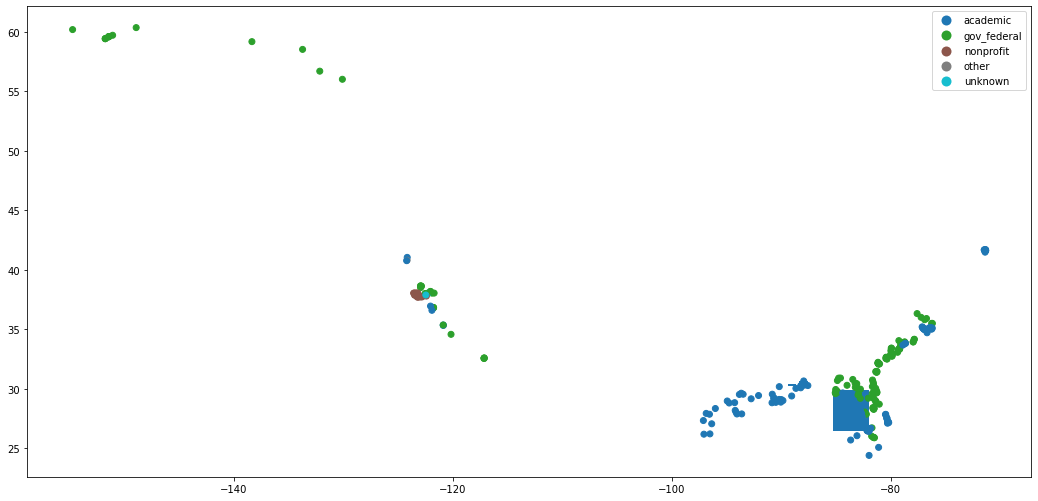

In [19]:
gdf.plot(column='creator_sector', figsize=(18, 18), legend=True)

#### Create a more complicated plot with world continents background.

**To Do:** 
- retrieve a bounding box from the GeoDataFrame and set plot extent to match (defaults to extent of largest dataset, in this case the natural earth background)

Text(0.5, 1.0, 'IOOS Catalog Dataset Coverage.  Filters - CF Std Name: mass_concentration_of_oxygen_in_sea_water, Org: None, Format: None')

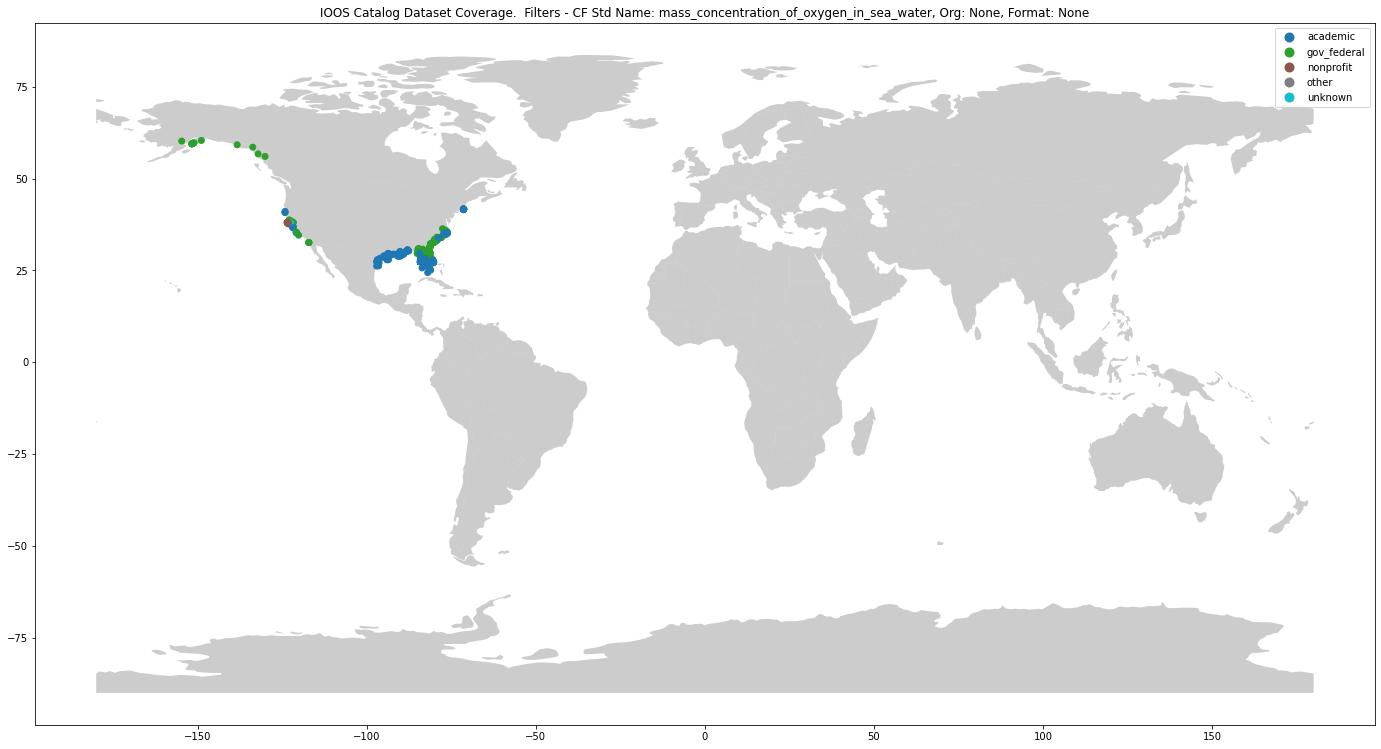

In [20]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(24,18))
world.plot(ax=ax, alpha=0.4, color='grey')
#gdf.plot(column='spatial', ax=ax, legend=True)
gdf.plot(ax=ax, column='creator_sector', legend=True)
plt.title(f"IOOS Catalog Dataset Coverage.  Filters - CF Std Name: {chart_params.sel_cf_std_name}, Org: {chart_params.sel_organization}, Format: {chart_params.sel_format}")

In [21]:
from folium import plugins

map = folium.Map(location = [15,30], tiles='Cartodb dark_matter', zoom_start = 2)

heat_data = [[geom.xy[1][0], geom.xy[0][0]] if geom.geom_type == "Point" else [geom.centroid.xy[1][0], geom.centroid.xy[0][0]] for geom in gdf.geometry ]

heat_data
plugins.HeatMap(heat_data).add_to(map)

map